In [1]:
import math, random, sys, os
sys.path.insert(0, '/workspace/icml18-jtnn_original')

In [2]:
from copy import copy

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
import pandas as pd;
import matplotlib.pyplot as plt;
from sklearn.decomposition import PCA;
from sklearn.linear_model import ElasticNet, Ridge;
from sklearn.ensemble import RandomForestRegressor;
from sklearn.preprocessing import PolynomialFeatures;
from sklearn.preprocessing import StandardScaler;

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tqdm import tqdm
import numpy as np
from CGRtools import smiles
from optparse import OptionParser
from collections import deque
from IPython.display import clear_output

from jtnn import *
import rdkit

    
lg = rdkit.RDLogger.logger() 
lg.setLevel(rdkit.RDLogger.CRITICAL)

In [6]:
from warnings import filterwarnings
filterwarnings("ignore")

## Functions and Constants

In [12]:
scale = 27.21
columns = ["tree", "homo", "lumo", "gap"]

In [7]:
def get_mae_loss(x, y):
    return np.mean(np.abs(x - y))

def get_mse_loss(x, y):
    return np.mean((x - y)**2)

def homo_lumo_gap_visualisation(X, y, step=1):
    plt.figure(figsize=(25, 5))
    ax = plt.subplot(131)
    ax.scatter(X_pca[::step, 0], X_pca[::step, 1], c = y[::step].homo)

    ax = plt.subplot(132)
    ax.scatter(X_pca[::step, 0], X_pca[::step, 2], c = y[::step].homo)

    ax = plt.subplot(133)
    ax.scatter(X_pca[::step, 1], X_pca[::step, 2], c = y[::step].homo)
    plt.show()


    plt.figure(figsize=(25, 5))
    ax = plt.subplot(131)
    ax.scatter(X_pca[::step, 0], X_pca[::step, 1], c = y[::step].lumo)

    ax = plt.subplot(132)
    ax.scatter(X_pca[::step, 0], X_pca[::step, 2], c = y[::step].lumo)

    ax = plt.subplot(133)
    ax.scatter(X_pca[::step, 1], X_pca[::step, 2], c = y[::step].lumo)
    plt.show()


    plt.figure(figsize=(25, 5))
    ax = plt.subplot(131)
    ax.scatter(X_pca[::step, 0], X_pca[::step, 1], c = y[::step].gap)

    ax = plt.subplot(132)
    ax.scatter(X_pca[::step, 0], X_pca[::step, 2], c = y[::step].gap)

    ax = plt.subplot(133)
    ax.scatter(X_pca[::step, 1], X_pca[::step, 2], c = y[::step].gap)
    plt.show()
    
def train_model(dataset, model, regressor, fLoss, batch_size, optimizer, optimizer_reg, scheduler, scheduler_reg, epoch, df):
    with torch.enable_grad():
        model.train()
        regressor.train()
        mse = 0
        mae = 0
        size = math.ceil(dataset.shape[0]/batch_size)
        pbar = tqdm(range(size))

        for i in pbar:
            model.zero_grad()
            regressor.zero_grad()
            prop = np.array(dataset[batch_size*i: batch_size*(i+1)]["target"], dtype=float).squeeze()

            features = model.get_embeddings(list(dataset[batch_size*i: batch_size*(i+1)]["tree"]))
            prediction = regressor(features)

            wloss = fLoss(prediction, torch.cuda.FloatTensor(prop)[:, None])
            wloss.backward()

            optimizer.step()
            optimizer_reg.step()

            mse += float(wloss.item())

            mae += get_mae_loss(prediction.cpu().detach().numpy().squeeze(), prop)

        df = df.append(pd.Series([epoch, 
                                  mse/size,
                                  mae/size,
                                  optimizer.param_groups[0]['lr'],
                                  optimizer_reg.param_groups[0]['lr']], index=df.columns), ignore_index=True)

        scheduler.step(df.iloc[-1, 1])
        scheduler_reg.step(df.iloc[-1, 1])
    
    return df
        
def test_model(dataset, model, regressor, batch_size, epoch, df):
    with torch.no_grad():
        model.eval()
        regressor.eval()
        mse = 0
        mae = 0
        size = math.ceil(dataset.shape[0]/batch_size)
        pbar = tqdm(range(size))

        for i in pbar:
            prop = np.array(dataset[batch_size*i: batch_size*(i+1)]["target"], dtype=float).squeeze()

            features = model.get_embeddings(list(dataset[batch_size*i: batch_size*(i+1)]["tree"]))
            prediction = regressor(features)
            
            mse += get_mse_loss(prediction.cpu().detach().numpy().squeeze(), prop)

            mae += get_mae_loss(prediction.cpu().detach().numpy().squeeze(), prop)

        df = df.append(pd.Series([epoch, 
                                  mse/size,
                                  mae/size,], index=df.columns), ignore_index=True)

    return df


def train_regression(trees, targets, model, regressor, fLoss, batch_size, optimizer_reg, epoch, df):
    with torch.enable_grad():
        model.eval()
        regressor.train()
        
        mse = 0
        mae = 0
        shape = len(trees)
        size = math.ceil(shape/batch_size)
        pbar = tqdm(range(size))

        for i in pbar:
            optimizer_reg.zero_grad()
            
            prop = targets[batch_size*i: batch_size*(i+1)]
            _, tree_vec, mol_vec = model.encode(list(trees[batch_size*i: batch_size*(i+1)]))
            tree_mean = model.T_mean(tree_vec)
            mol_mean = model.G_mean(mol_vec)
            features = torch.cuda.FloatTensor(torch.cat([tree_mean,mol_mean], dim=1))

            prediction = regressor(features)

            wloss = fLoss(prediction, (torch.cuda.FloatTensor(prop.to_numpy())))
            wloss.backward()

            optimizer_reg.step()

            mse += float(wloss.item())
            mae += get_mae_loss(prediction.cpu().detach().numpy().squeeze(), np.array(prop))

        df = df.append(pd.Series([epoch, 
                                  mse/size,
                                  mae/size,
                                  optimizer_reg.param_groups[0]['lr']], index=df.columns), ignore_index=True)
    return df
        
def test_regression(trees, targets, model, regressor, batch_size, epoch, df):
    with torch.no_grad():
        model.eval()
        regressor.eval()
        mse = 0
        mae = 0
        
        shape = len(trees)
        size = math.ceil(shape/batch_size)
        pbar = tqdm(range(size))

        for i in pbar:
            prop = targets[batch_size*i: batch_size*(i+1)]

            _, tree_vec, mol_vec = model.encode(list(trees[batch_size*i: batch_size*(i+1)]))
            tree_mean = model.T_mean(tree_vec)
            mol_mean = model.G_mean(mol_vec)
            features = torch.cuda.FloatTensor(torch.cat([tree_mean,mol_mean], dim=1))

            prediction = regressor(features)
            
            mse += get_mse_loss(prediction.cpu().detach().numpy().squeeze(), prop)

            mae += get_mae_loss(prediction.cpu().detach().numpy().squeeze(), prop)

        df = df.append(pd.Series([epoch, 
                                  mse/size,
                                  mae/size,], index=df.columns), ignore_index=True)

    return df

def train_two_outputs(trees, targets, model, regressor, fLoss, batch_size, optimizer_reg, scheduler_reg, epoch, df):
    with torch.enable_grad():
        regressor.train()
        
        mse = 0
        mae = 0
        shape,  = trees.shape
        size = math.ceil(shape/batch_size)

        for i in range(size):
            optimizer_reg.zero_grad()
            prop = targets[batch_size*i: batch_size*(i+1)]

            _, tree_vec, mol_vec = model.encode(list(trees[batch_size*i: batch_size*(i+1)]))
            tree_mean = model.T_mean(tree_vec)
            mol_mean = model.G_mean(mol_vec)
            features = torch.cuda.FloatTensor(torch.cat([tree_mean,mol_mean], dim=1))
            
            prediction = regressor(features)
            
            wloss = fLoss(prediction, torch.cuda.FloatTensor(prop.to_numpy()))
            wloss = wloss.sum(dim=1).mean(dim=0)
            wloss.backward()

            optimizer_reg.step()

            mse += float(wloss.item()*prop.shape[0])
            mae += (nn.L1Loss(reduction="none")(prediction, torch.cuda.FloatTensor(prop.to_numpy())).sum()).item()

        df = df.append(pd.Series([epoch, 
                                  mse/shape,
                                  mae/shape,
                                  optimizer_reg.param_groups[0]['lr']], index=df.columns), ignore_index=True)

    return df

def test_two_outputs(trees, targets, model, regressor, batch_size, epoch, df):
    with torch.no_grad():
        regressor.eval()
        mse = 0
        mae = 0
        shape,  = trees.shape
        size = math.ceil(shape/batch_size)

        for i in range(size):
            prop = targets[batch_size*i: batch_size*(i+1)]

            features = model.get_embeddings(list(trees[batch_size*i: batch_size*(i+1)]))
            prediction = regressor(features)
            
            mse += (nn.MSELoss(reduction="none")(prediction, torch.cuda.FloatTensor(prop.to_numpy())).sum()).item()
            
            mae += (nn.L1Loss(reduction="none")(prediction, torch.cuda.FloatTensor(prop.to_numpy())).sum()).item()

        df = df.append(pd.Series([epoch, 
                                  mse/shape,
                                  mae/shape], index=df.columns), ignore_index=True)

    return df

def verbose_epoch(df_train, df_test):
        clear_output(True)

        plt.figure(figsize=(25, 5))

        ax = plt.subplot(121)
        ax.plot(df_train["MSE Loss"])
        ax.plot(df_test["MSE Loss"])
        ax.set_title("MSE\nTrain: {:.3f}\nTest: {:.3f}".format(df_train["MSE Loss"].iloc[-1], df_test["MSE Loss"].iloc[-1]))

        ax = plt.subplot(122)
        ax.plot(df_train["MAE Loss"])
        ax.plot(df_test["MAE Loss"])
        ax.set_title("MAE\nTrain: {:.3f}\nTest: {:.3f}".format(df_train["MAE Loss"].iloc[-1], df_test["MAE Loss"].iloc[-1]))
    
        plt.show()

## Data extraction

In [8]:
vocab_path = "data/merged/vocab.txt"
vocab = [x.strip("\r\n ") for x in open(vocab_path)]
cset = set(vocab)
vocab = Vocab(vocab)

In [9]:
data = pd.read_csv("data/merged/all.txt")

In [10]:
df_train = pd.read_csv("data/merged/csv/train_reg.csv")
df_test = pd.read_csv("data/merged/csv/test_reg.csv")
df_val = pd.read_csv("data/merged/csv/val_reg.csv")

In [13]:
df_train.homo = df_train.homo*scale
df_train.lumo = df_train.lumo*scale
df_train.gap = df_train.gap*scale

In [14]:
df_test.homo = df_test.homo*scale
df_test.lumo = df_test.lumo*scale
df_test.gap = df_test.gap*scale

In [15]:
df_val.homo = df_val.homo*scale
df_val.lumo = df_val.lumo*scale
df_val.gap = df_val.gap*scale

## Creation of molecular tree

In [ ]:
df = df_train

lines = []
size, cols = df.shape
pbar = tqdm(range(size))


for i in pbar:
    line = df.loc[i]
    mol_tree = MolTree(line.smiles)
    mol_tree.recover()
    mol_tree.assemble()
    lines.append([mol_tree, line.homo, line.lumo, line.gap])

tree_train = pd.DataFrame(lines, columns = columns)

  8% 9962/121940 [37:05<6:02:56,  5.14it/s] 

In [ ]:
df = df_test

lines = []
size, cols = df.shape
pbar = tqdm(range(size))


for i in pbar:
    line = df.loc[i]
    mol_tree = MolTree(line.smiles)
    mol_tree.recover()
    mol_tree.assemble()
    lines.append([mol_tree, line.homo, line.lumo, line.gap])
    
tree_test = pd.DataFrame(lines, columns = columns)

In [ ]:
df = df_val

lines = []
size, cols = df.shape
pbar = tqdm(range(size))


for i in pbar:
    line = df.loc[i]
    mol_tree = MolTree(line.smiles)
    mol_tree.recover()
    mol_tree.assemble()
    lines.append([mol_tree, line.homo, line.lumo, line.gap])
    
tree_val = pd.DataFrame(lines, columns = columns)

## Neural networks

## Test here if requiered

In [87]:
modelvae_path = 'reg_model/merged_qdb9_256_612_homo/decoder_bigger_batch/model'
model1 = JTNNVAE(vocab, hidden_size, latent_size, depth, stereo=stereo)
model1.load_state_dict(torch.load(modelvae_path))

modelvae_path = 'reg_model/merged_qdb9_256_612_homo/model'
model2 = JTNNVAE(vocab, hidden_size, latent_size, depth, stereo=stereo)
model2.load_state_dict(torch.load(modelvae_path))

<All keys matched successfully>

In [88]:
for weight1,  weight2 in zip(model1.jtnn.parameters(), model2.jtnn.parameters()):
    size = len(weight2.flatten())
    print("{:2f} % ".format(((weight1 == weight2).sum()/size).item()))

for weight1,  weight2 in zip(model1.jtmpn.parameters(), model2.jtmpn.parameters()):
    size = len(weight2.flatten())
    print("{:2f} % ".format(((weight1 == weight2).sum()/size).item()))
    
size = len(model1.embedding.weight.flatten())
print("{:2f} % ".format(((model1.embedding.weight == model2.embedding.weight).sum()/size).item()))

size = len(model1.G_mean.weight.flatten())
print("{:2f} % ".format(((model1.G_mean.weight == model2.G_mean.weight).sum()/size).item()))

size = len(model1.T_mean.weight.flatten())
print("{:2f} % ".format(((model1.G_mean.weight == model2.G_mean.weight).sum()/size).item()))

1.000000 % 
1.000000 % 
1.000000 % 
1.000000 % 
1.000000 % 
1.000000 % 
1.000000 % 
1.000000 % 
1.000000 % 
1.000000 % 
1.000000 % 
1.000000 % 
1.000000 % 
1.000000 % 
1.000000 % 
1.000000 % 
1.000000 % 


In [89]:
hidden_size = 612
latent_size = 256
depth = 3
stereo = True
batch_size = 8192
random_state = 42

regression_path = 'reg_model/merged_qdb9_256_612_homo/model_regression'
modelvae_path = 'reg_model/merged_qdb9_256_612_homo/decoder/model'

regressor = nn.Sequential(
    nn.Linear(latent_size, 4096),
    nn.ReLU(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Linear(4096, 1))

model = JTNNVAE(vocab, hidden_size, latent_size, depth, stereo=stereo)

model = model.cuda()
regressor = regressor.cuda()

model.load_state_dict(torch.load(modelvae_path))
regressor.load_state_dict(torch.load(regression_path))

_ = model.eval()
_ = regressor.eval()

In [90]:
fLoss = nn.L1Loss(reduction="mean")
test_verbose_lumo = pd.DataFrame(columns=["Step", "MSE Loss", "MAE Loss"])
test_dataset = pd.DataFrame(columns = ["tree", "target"])
test_dataset[["tree", "target"]] = tree_test[["tree", "homo"]]
test_verbose_lumo = test_model(test_dataset, model, regressor, batch_size, 0, test_verbose_lumo)

test_verbose_lumo.head()

100% 1/1 [00:08<00:00,  8.26s/it]


,Step,MSE Loss,MAE Loss
0,0.0,0.046164,0.137499


## Tunning of neural networks

In [29]:
lr, lr_reg = 0.001, 0.01 
hidden_size = 612
latent_size = 256
depth = 3
stereo = True
modelvae_path = 'vae_model/merged_qdb9_256_612/model'
batch_size = 8192
random_state = 42

regressor = nn.Sequential(
    nn.Linear(latent_size, 4096),
    nn.ReLU(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Linear(4096, 1),
)

for param in regressor.parameters():
    if param.dim() == 1:
        nn.init.constant_(param, 0)
    else:
        nn.init.xavier_normal_(param)

model = JTNNVAE(vocab, hidden_size, latent_size, depth, stereo=stereo)
model.load_state_dict(torch.load(modelvae_path))


model = model.cuda()
regressor = regressor.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,mode="min",factor=0.5, patience=3, min_lr=1e-6)

optimizer_reg = optim.Adam(regressor.parameters(), lr=lr_reg)
scheduler_reg = lr_scheduler.ReduceLROnPlateau(optimizer_reg, mode="min",factor=0.5, patience=3, min_lr=1e-6)

fLoss = nn.L1Loss(reduction="mean")
train_verbose_lumo = pd.DataFrame(columns=["Step", "MSE Loss", "MAE Loss", "LR_enc", "LR_reg"])
test_verbose_lumo = pd.DataFrame(columns=["Step", "MSE Loss", "MAE Loss"])

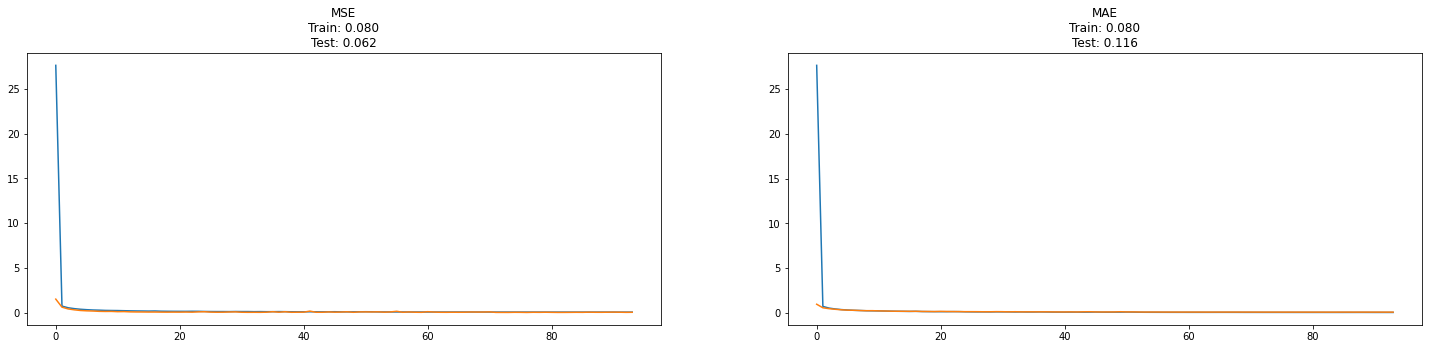

In [32]:
train_dataset = pd.DataFrame(columns = ["tree", "target"])
test_dataset = pd.DataFrame(columns = ["tree", "target"])

train_dataset[["tree", "target"]] = tree_train[["tree", "lumo"]]
test_dataset[["tree", "target"]] = tree_test[["tree", "lumo"]]

try:
    for epoch in range(93):
        train_verbose_lumo = train_model(train_dataset, model, regressor, fLoss, batch_size, optimizer, optimizer_reg, scheduler, scheduler_reg, 57+ epoch, train_verbose_lumo)
        test_verbose_lumo = test_model(test_dataset, model, regressor, batch_size, epoch, test_verbose_lumo)
        verbose_epoch(train_verbose_lumo, test_verbose_lumo)
        
        
        
except KeyboardInterrupt:
    verbose_epoch(train_verbose_lumo, test_verbose_lumo)

In [34]:
dir_name = 'merged_qdb9_256_612_lumo'
os.mkdir("reg_model/"+dir_name)
torch.save(regressor.state_dict(), "reg_model/" + dir_name + "/model_regression")
torch.save(model.state_dict(), "reg_model/" + dir_name + "/model")

In [43]:
lr, lr_reg = 0.001, 0.01 

regressor = nn.Sequential(
    nn.Linear(latent_size, 4096),
    nn.ReLU(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Linear(4096, 1),
)

for param in regressor.parameters():
    if param.dim() == 1:
        nn.init.constant_(param, 0)
    else:
        nn.init.xavier_normal_(param)

model = JTNNVAE(vocab, hidden_size, latent_size, depth, stereo=stereo)
model.load_state_dict(torch.load(modelvae_path))

model = model.cuda()
regressor = regressor.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,mode="min",factor=0.5, patience=3, min_lr=1e-6)

optimizer_reg = optim.Adam(regressor.parameters(), lr=lr_reg)
scheduler_reg = lr_scheduler.ReduceLROnPlateau(optimizer_reg, mode="min",factor=0.5, patience=3, min_lr=1e-6)

fLoss = nn.L1Loss(reduction="mean")
train_verbose_homo = pd.DataFrame(columns=["Step", "MSE Loss", "MAE Loss", "LR_enc", "LR_reg"])
test_verbose_homo = pd.DataFrame(columns=["Step", "MSE Loss", "MAE Loss"])

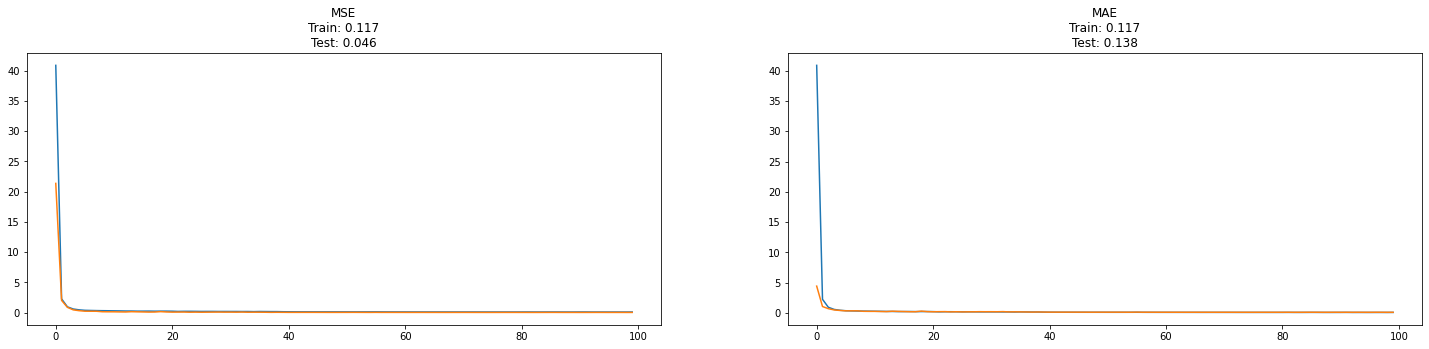

In [44]:
train_dataset = pd.DataFrame(columns = ["tree", "target"])
test_dataset = pd.DataFrame(columns = ["tree", "target"])

train_dataset[["tree", "target"]] = tree_train[["tree", "homo"]]
test_dataset[["tree", "target"]] = tree_test[["tree", "homo"]]

try:
    for epoch in range(100):
        train_verbose_homo = train_model(train_dataset, model, regressor, fLoss, batch_size, optimizer, optimizer_reg, scheduler, scheduler_reg, epoch, train_verbose_homo)
        test_verbose_homo = test_model(test_dataset, model, regressor, batch_size, epoch, test_verbose_homo)
        verbose_epoch(train_verbose_homo, test_verbose_homo)
        
        
except KeyboardInterrupt:
    verbose_epoch(train_verbose_homo, test_verbose_homo)

In [45]:
dir_name = 'merged_qdb9_256_612_homo'
os.mkdir("reg_model/"+dir_name)
torch.save(regressor.state_dict(), "reg_model/" + dir_name + "/model_regression")
torch.save(model.state_dict(), "reg_model/" + dir_name + "/model")

In [46]:
lr, lr_reg = 0.001, 0.01 

regressor = nn.Sequential(
    nn.Linear(latent_size, 4096),
    nn.ReLU(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Linear(4096, 1),
)

for param in regressor.parameters():
    if param.dim() == 1:
        nn.init.constant_(param, 0)
    else:
        nn.init.xavier_normal_(param)

model = JTNNVAE(vocab, hidden_size, latent_size, depth, stereo=stereo)
model.load_state_dict(torch.load(modelvae_path))


model = model.cuda()
regressor = regressor.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,mode="min",factor=0.5, patience=3, min_lr=1e-6)

optimizer_reg = optim.Adam(regressor.parameters(), lr=lr_reg)
scheduler_reg = lr_scheduler.ReduceLROnPlateau(optimizer_reg, mode="min",factor=0.5, patience=3, min_lr=1e-6)

fLoss = nn.L1Loss(reduction="mean")
MAX_EPOCH = 10

train_verbose_gap = pd.DataFrame(columns=["Step", "MSE Loss", "MAE Loss", "LR_enc", "LR_reg"])
test_verbose_gap = pd.DataFrame(columns=["Step", "MSE Loss", "MAE Loss"])

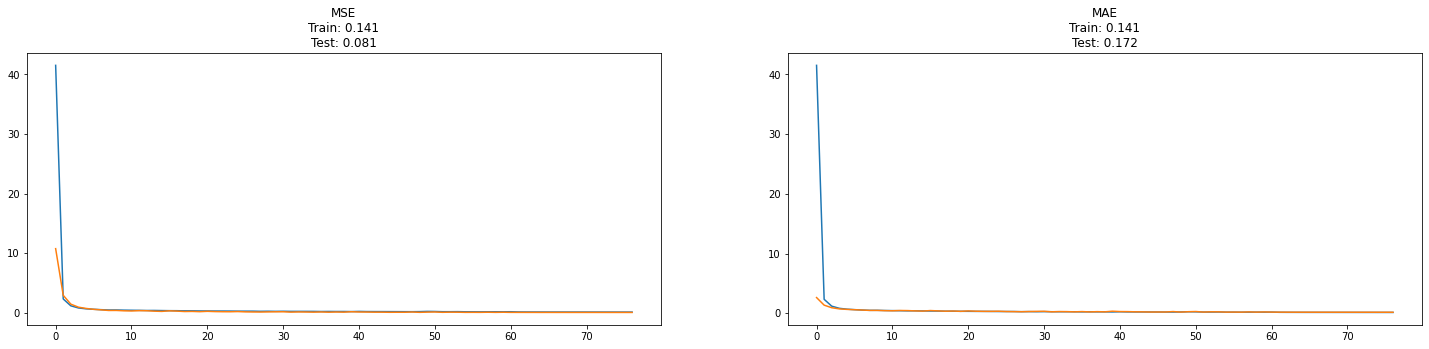

 40%|████      | 6/15 [02:45<04:05, 27.26s/it]

In [ ]:
train_dataset = pd.DataFrame(columns = ["tree", "target"])
test_dataset = pd.DataFrame(columns = ["tree", "target"])

train_dataset[["tree", "target"]] = tree_train[["tree", "gap"]]
test_dataset[["tree", "target"]] = tree_test[["tree", "gap"]]

try:
    for epoch in range(100):
        train_verbose_gap = train_model(train_dataset, model, regressor, fLoss, batch_size, optimizer, optimizer_reg, scheduler, scheduler_reg, epoch, train_verbose_gap)
        test_verbose_gap = test_model(test_dataset, model, regressor, batch_size, epoch, test_verbose_gap)
        verbose_epoch(train_verbose_gap, test_verbose_gap)
        
        
except KeyboardInterrupt:
    verbose_epoch(train_verbose_gap, test_verbose_gap)

In [ ]:
dir_name = 'merged_qdb9_256_612_gap'
os.mkdir("reg_model/"+dir_name)
torch.save(regressor.state_dict(), "reg_model/" + dir_name + "/model_regression")
torch.save(model.state_dict(), "reg_model/" + dir_name + "/model")

| Method   |Train | Test   | U0   | E    | HOMO | LUMO |
| --- | --- | --- | --- | --- | --- | --- |
| Random Forest | QM9  | QM9   | - | - | - | - |
| EN (CM)  | QM9  | QM9    | 21.1 | 22.0 | 0.34 | 0.64 |
| KRR (CM) | QM9  | QM9    | 4.9  | 5.2  | 0.18 | 0.25 |
| SchNet   | QM9  | QM9    | 0.3  | 1.0  | 0.04 | 0.03 |
| JT-VAE   | QM9  | QM9    | -  | -  | - | 0.09 |
| JT-VAE   | QM9, ZINC | QM9 |  -  | -  | - | 0.09|

| Method   |Train | Test   | Acc   | Val| KL |
| --- | --- | --- | --- | --- | --- | 
| JT-VAE   | QM9, ZINC | QM9 | 0.830850  | 0.999500   | True | 
| JT-VAE   | QM9 | QM9 | 0.819372  | 0.999500  | True  | 
| JT-VAE   | QM9 | QM9 |   0.793596  | 0.999500   | False   |
| JT-VAE   | QM9, ZINC | QM9 |   0.809505  | 0.999500   | False   | 

| Method   |Train | Test     | E    | HOMO | LUMO |
| --- | --- | --- | --- | --- | --- |
|EN (CM)  | PC9  | PC9     | 38.2 | 0.47 | 0.66 |
| KRR (CM) | PC9  | PC9       | 22.8 | 0.31 | 0.36 |
| SchNet   | PC9  | PC9        | 1.6  | 0.06 | 0.05 |
| SchNet   | QM9  | PC9(A)    | 3.0  | 0.07 | 0.06 |
| SchNet   | QM9  | PC9(B)   | 8.9  | 0.33 | 0.27 | 
| SchNet   | PC9  | QM9(A)    | 3.4  | 0.05 | 0.05 |
| SchNet   | PC9  | QM9(B)   | 4.2  | 0.12 | 0.11 |
| EN (CM)  | QM9  | QM9    | -- | 0.34 | 0.64 |
| KRR (CM) | QM9  | QM9    | --   | 0.18 | 0.25 |
| SchNet   | QM9  | QM9   | --  | 0.04 | 0.03 |
| JT-VAE   | QM9  | QM9   | -  | - | 0.09 |
| JT-VAE   | QM9, ZINC | QM9  | -  | - | 0.09|

In [141]:
lr_reg = 0.01
hidden_size = 612
latent_size = 256
depth = 3
stereo = True
modelvae_path = 'vae_model/merged_qdb9_256_612/model'
batch_size = 16384
random_state = 42

regressor = nn.Sequential(
    nn.Linear(latent_size, 4096),
    nn.ReLU(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Linear(4096, 1),
)

for param in regressor.parameters():
    if param.dim() == 1:
        nn.init.constant_(param, 0)
    else:
        nn.init.xavier_normal_(param)

model = JTNNVAE(vocab, hidden_size, latent_size, depth, stereo=stereo)
model.load_state_dict(torch.load(modelvae_path))

for param in model.parameters():
    param.requires_grad = False


model = model.cuda()
model.eval()
regressor = regressor.cuda()

optimizer_reg = optim.Adam(regressor.parameters(), lr=lr_reg)
scheduler_reg = lr_scheduler.MultiplicativeLR(optimizer_reg, lr_lambda=lambda x: 0.1)

fLoss = nn.MSELoss(reduction="mean")
train_search_verbose_lumo = pd.DataFrame(columns=["Step", "MSE Loss", "MAE Loss", "LR_reg"])
test_search_verbose_lumo = pd.DataFrame(columns=["Step", "MSE Loss", "MAE Loss"])

In [ ]:
try:
    for epoch in range(200):
        if not((epoch+1)%30):
            scheduler_reg.step()
            
        train_search_verbose_lumo = train_regression(tree_train["tree"], tree_train["homo"], model, regressor, fLoss, batch_size, optimizer_reg, epoch, train_search_verbose_lumo)
        test_search_verbose_lumo = test_regression(tree_test["tree"], tree_test["homo"], model, regressor, batch_size, epoch, test_search_verbose_lumo)
    
        verbose_epoch(train_search_verbose_lumo, test_search_verbose_lumo)

except KeyboardInterrupt:
        verbose_epoch(train_search_verbose_lumo, test_search_verbose_lumo)

In [130]:
dir_name = 'merged_search_qdb9_256_612_lumo'
os.mkdir("reg_model/"+dir_name)
torch.save(regressor.state_dict(), "reg_model/" + dir_name + "/model_regression")
torch.save(model.state_dict(), "reg_model/" + dir_name + "/model")

In [148]:
regressor = nn.Sequential(
    nn.Linear(latent_size, 4096),
    nn.ReLU(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Linear(4096, 1),
)

for param in regressor.parameters():
    if param.dim() == 1:
        nn.init.constant_(param, 0)
    else:
        nn.init.xavier_normal_(param)

model = JTNNVAE(vocab, hidden_size, latent_size, depth, stereo=stereo)
model.load_state_dict(torch.load(modelvae_path))

for param in model.parameters():
    param.requires_grad = False

model = model.cuda()
model.eval()
regressor = regressor.cuda()

optimizer_reg = optim.Adam(regressor.parameters(), lr=lr_reg)
scheduler_reg = lr_scheduler.ReduceLROnPlateau(optimizer_reg, mode="min",factor=0.5, patience=3, min_lr=1e-6)

fLoss = nn.L1Loss(reduction="mean")
train_search_verbose_homo = pd.DataFrame(columns=["Step", "MSE Loss", "MAE Loss", "LR_reg"])
test_search_verbose_homo = pd.DataFrame(columns=["Step", "MSE Loss", "MAE Loss"])

In [ ]:
try:
    for epoch in range(200):
        if not((epoch+1)%100):
            scheduler_reg.step()
            
        train_search_verbose_homo = train_regression(tree_train["tree"], tree_train["homo"], model, regressor, fLoss, batch_size, optimizer_reg, epoch, train_search_verbose_homo)
        test_search_verbose_homo = test_regression(tree_test["tree"], tree_test["homo"], model, regressor, batch_size, epoch, test_search_verbose_homo)
    
        verbose_epoch(train_search_verbose_homo, test_search_verbose_homo)

except KeyboardInterrupt:
        verbose_epoch(train_search_verbose_homo, test_search_verbose_homo)

 62%|██████▎   | 5/8 [02:30<01:28, 29.47s/it]

In [ ]:
dir_name = 'merged_search_qdb9_256_612_homo'
os.mkdir("reg_model/"+dir_name)
torch.save(regressor.state_dict(), "reg_model/" + dir_name + "/model_regression")
torch.save(model.state_dict(), "reg_model/" + dir_name + "/model")

In [212]:
regressor = nn.Sequential(
    nn.Linear(latent_size, 4096),
    nn.ReLU(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Linear(4096, 2),
)

for param in regressor.parameters():
    if param.dim() == 1:
        nn.init.constant_(param, 0)
    else:
        nn.init.xavier_normal_(param)

model = JTNNVAE(vocab, hidden_size, latent_size, depth, stereo=stereo)
model.load_state_dict(torch.load(modelvae_path))

for param in model.parameters():
    param.requires_grad = False

model = model.cuda()
model.eval()
regressor = regressor.cuda()

optimizer_reg = optim.Adam(regressor.parameters(), lr=lr_reg)
scheduler_reg = lr_scheduler.ReduceLROnPlateau(optimizer_reg, mode="min",factor=0.5, patience=3, min_lr=1e-6)

fLoss = nn.L1Loss(reduction="none")
train_search_verbose_two = pd.DataFrame(columns=["Step", "MSE Loss", "MAE Loss", "LR_reg"])
test_search_verbose_two = pd.DataFrame(columns=["Step", "MSE Loss", "MAE Loss"])

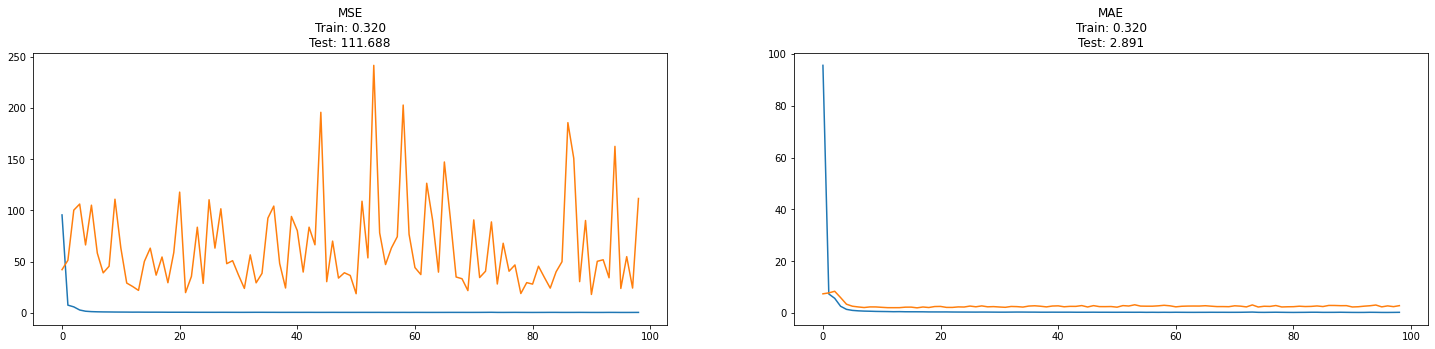

TypeError: step() missing 1 required positional argument: 'metrics'

In [213]:
try:
    for epoch in range(200):
        if not((epoch+1)%100):
            scheduler_reg.step()
        
        test_search_verbose_two = test_two_outputs(tree_test["tree"], tree_test[["homo", "lumo"]], model, regressor, batch_size, epoch, test_search_verbose_two)
        train_search_verbose_two = train_two_outputs(tree_train["tree"], tree_train[["homo", "lumo"]], model, regressor, fLoss, batch_size, optimizer_reg, scheduler_reg, epoch, train_search_verbose_two)
        verbose_epoch(train_search_verbose_two, test_search_verbose_two)

except KeyboardInterrupt:
        verbose_epoch(train_search_verbose_two, test_search_verbose_two)

In [ ]:
dir_name = 'merged_search_qdb9_256_612_two'
os.mkdir("reg_model/"+dir_name)
torch.save(regressor.state_dict(), "reg_model/" + dir_name + "/model_regression")
torch.save(model.state_dict(), "reg_model/" + dir_name + "/model")

### Latent descent

In [53]:
def latent_space_descent(variables, target, regression, loss, opt, n_steps = 1):
    regressor.train()
    props = (torch.ones(variables.size()[0], 1)*target).cuda()
        
    for i in range(n_steps):
        regressor.zero_grad()
        opt.zero_grad()
        
        prediction = regressor(variables)
        wloss = loss(prediction, props)
        wloss.backward()
        opt.step()
        
    return prediction.cpu().detach().numpy()

In [54]:
def visualise(variables, properties, model):
    tree_vec, mol_vec = torch.split(variables, variables.size()[1]//2, 1)
    
    s = []
    for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
        _s = smiles(model.decode(tree[None, :],mol[None, :], False))
        _s.clean_stereo()
        _s.canonicalize()

        s.append(_s.__str__())
        
    for i, mol in enumerate(s):
        print("Generated molecule: {} with predicted coeficient {:.3f}".format(mol, properties[i][0]))

In [55]:
lr_mol = 0.1 

molecules = torch.tensor(torch.rand([10,256]), device="cuda", requires_grad=True)


regressor = nn.Sequential(
    nn.Linear(latent_size, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
)
model = JTNNVAE(vocab, hidden_size, latent_size, depth, stereo=stereo)


regression_path = "reg_model/qdb9_zinc_prunned_256_gap_search/model_regression"
modelvae_path = 'vae_model/qdb9_zinc_prunned_256/model'

model.load_state_dict(torch.load(modelvae_path))
regressor.load_state_dict(torch.load(regression_path))

for param in model.parameters():
    param.requires_grad = False

model = model.cuda()
regressor = regressor.cuda()

lr_mol = 0.1 
molecules = torch.tensor(torch.rand([10,256]), device="cuda", requires_grad=True)
optimizer = optim.Adam([molecules], lr=lr_mol)

In [1047]:
for i in range(50):
    resulting_properties = latent_space_descent(molecules, 0, regressor, nn.MSELoss(), optimizer, 1)
    
    clear_output(wait=True)
    visualise(molecules, resulting_properties, model)

Generated molecule: c1c(cc(cc1)F)C(=O)N with predicted coeficient 4.987
Generated molecule: c1cc(ccc1C(C=O)N2C3C=CC=CC3C=CC2)OC with predicted coeficient 4.987
Generated molecule: C(C(c1cccc(c1)OC)=O)=O with predicted coeficient 4.987
Generated molecule: c1cc(ccc1CNC(=O)C(C)Oc2ccc(cc2)C#N)[NH3+] with predicted coeficient 4.987
Generated molecule: c1c(C(Nc2c(OC)cccc2)=O)ncc(C([O-])=O)c1 with predicted coeficient 4.987
Generated molecule: c1cc(ccc1F)C[NH2+]C(C(=O)N2C(C)CCCC2)C with predicted coeficient 4.987
Generated molecule: C1CC(C)(C#N)C1O with predicted coeficient 4.987
Generated molecule: c1cc(ccc1C=O)NC(C(=O)[O-])C with predicted coeficient 4.987
Generated molecule: C1C(CC1C([O-])=O)=O with predicted coeficient 4.987
Generated molecule: O=C(C(N)C=O)NC=O with predicted coeficient 4.987


In [1048]:
lr_mol = 0.1
molecules = torch.tensor(torch.rand([10,256]), device="cuda", requires_grad=True)
optimizer = optim.Adam([molecules], lr=lr_mol)

for i in range(50):
    resulting_properties = latent_space_descent(molecules, 10, regressor, nn.MSELoss(), optimizer, 1)
    
    clear_output(wait=True)
    visualise(molecules, resulting_properties, model)

Generated molecule: CC1(C)C([NH2+]C2(CC2)C)CC1 with predicted coeficient 9.956
Generated molecule: C1CC1C(N2CCC2O)C with predicted coeficient 9.957
Generated molecule: C1CN(CCO1)C2CCC2(CO)C with predicted coeficient 9.960
Generated molecule: C1C(C(C#N)C1)O with predicted coeficient 10.074
Generated molecule: C1CC1(OC(C)C)C#N with predicted coeficient 9.905
Generated molecule: C1C(C(C)C1)O with predicted coeficient 10.035
Generated molecule: OC(O)C1(C(CC1)NC(C#C)=O)C with predicted coeficient 10.085
Generated molecule: C1CC(C)(C#N)C1O with predicted coeficient 10.072
Generated molecule: C1CC12CCC(CO2)C#N with predicted coeficient 10.000
Generated molecule: C1C(CC1C)[NH3+] with predicted coeficient 10.028


In [1049]:
lr_mol = 0.1
molecules = torch.tensor(torch.rand([10,256]), device="cuda", requires_grad=True)
optimizer = optim.Adam([molecules], lr=lr_mol)

for i in range(50):
    resulting_properties = latent_space_descent(molecules, 7, regressor, nn.MSELoss(), optimizer, 1)
    
    clear_output(wait=True)
    visualise(molecules, resulting_properties, model)

Generated molecule: C1CN1C2C(CC2)(CO)C with predicted coeficient 7.012
Generated molecule: C1CC1OCC(C#C)C with predicted coeficient 7.003
Generated molecule: C(#N)C1(OC(N)CC1)C with predicted coeficient 7.039
Generated molecule: C1CC2(C(O)NC2)C(C)O1 with predicted coeficient 7.007
Generated molecule: O1C(C1)C23CC3N=COC2 with predicted coeficient 6.980
Generated molecule: C1CC12C3N=COCC3C2C with predicted coeficient 6.987
Generated molecule: OCC1(CCC1=O)C with predicted coeficient 7.001
Generated molecule: C1(C(CC1)=N)(C#C)C with predicted coeficient 6.993
Generated molecule: c1ccc(F)c(OCC(C#C)C)c1 with predicted coeficient 7.031
Generated molecule: C(C)(C=O)C(=O)N with predicted coeficient 4.987


In [1050]:
lr_mol = 0.1
molecules = torch.tensor(torch.rand([10,256]), device="cuda", requires_grad=True)
optimizer = optim.Adam([molecules], lr=lr_mol)

for i in range(50):
    resulting_properties = latent_space_descent(molecules, 6, regressor, nn.MSELoss(), optimizer, 1)
    
    clear_output(wait=True)
    visualise(molecules, resulting_properties, model)

Generated molecule: O=CC(C)OCC1CO1 with predicted coeficient 5.999
Generated molecule: C1COC12C=C(CCC2)C with predicted coeficient 6.018
Generated molecule: c1cc(ccc1C(C=O)N2C(CCC2)C)F with predicted coeficient 4.987
Generated molecule: c1cc(ccc1NC(=O)C(=O)[O-])-c2ccc(cc2)OC with predicted coeficient 4.987
Generated molecule: c1c(NC(=O)CC(=O)C)cc(cc1)F with predicted coeficient 5.977
Generated molecule: OCC1C(=O)CC1 with predicted coeficient 5.994
Generated molecule: C1CC12CC(C2=O)C with predicted coeficient 6.001
Generated molecule: C1CC1(N)C(O)C=O with predicted coeficient 5.991
Generated molecule: C1C(CC1)(C=O)C with predicted coeficient 6.018
Generated molecule: NC(C)C1CCOC1=O with predicted coeficient 6.014


In [1051]:
lr_mol = 0.1
molecules = torch.tensor(torch.rand([10,256]), device="cuda", requires_grad=True)
optimizer = optim.Adam([molecules], lr=lr_mol)

for i in range(50):
    resulting_properties = latent_space_descent(molecules, 5, regressor, nn.MSELoss(), optimizer, 1)
    
    clear_output(wait=True)
    visualise(molecules, resulting_properties, model)

Generated molecule: FC(F)COc1cc(ccc1)C(=O)N with predicted coeficient 4.987
Generated molecule: C1CCC1C(c2cccc(N)c2)=O with predicted coeficient 4.987
Generated molecule: c1cc(c(cc1C(NCC)C=O)F)OC with predicted coeficient 4.987
Generated molecule: c1c(cc(cc1)N)C(=O)NCC(=O)C with predicted coeficient 4.987
Generated molecule: c1ccc(nc1C(=O)N)NC(=O)CC with predicted coeficient 4.987
Generated molecule: c1cc(ccc1OC)C(NCC(=O)[O-])=O with predicted coeficient 4.987
Generated molecule: c1cc(ccc1C(=O)NCC(C)c2ccccc2F)[N+](=O)[O-] with predicted coeficient 4.987
Generated molecule: C=1C2(N)C(C=CC=1)(C#C)COC=N2 with predicted coeficient 4.987
Generated molecule: c1c([N+]([O-])=O)c(ccc1C([O-])=O)C with predicted coeficient 4.987
Generated molecule: O=C1CC2(C13NC2C=C3)N with predicted coeficient 4.987


In [1052]:
lr_mol = 0.1
molecules = torch.tensor(torch.rand([10,256]), device="cuda", requires_grad=True)
optimizer = optim.Adam([molecules], lr=lr_mol)

for i in range(50):
    resulting_properties = latent_space_descent(molecules, 15, regressor, nn.MSELoss(), optimizer, 1)
    
    clear_output(wait=True)
    visualise(molecules, resulting_properties, model)

Generated molecule: O=C(CC)C#C with predicted coeficient 14.772
Generated molecule: C1CC1OC(C23CCCOC3C=CC=C2)C with predicted coeficient 14.682
Generated molecule: CC(C)OCC#N with predicted coeficient 14.960
Generated molecule: C1CC12CCC2(C)C[NH3+] with predicted coeficient 15.154
Generated molecule: C1CC1C(C)OC(C)C#N with predicted coeficient 14.928
Generated molecule: C1CC1OC(C)C with predicted coeficient 14.867
Generated molecule: CC(C)C#N with predicted coeficient 15.016
Generated molecule: C1COCCC1C2(CC2)OC(C)CC with predicted coeficient 14.882
Generated molecule: C1CC1([NH3+])C(C)C#N with predicted coeficient 15.072
Generated molecule: c1ccc(F)c(OC(NCC(C#N)C)=[NH2+])c1 with predicted coeficient 15.150


In [1053]:
lr_mol = 0.1
molecules = torch.tensor(torch.rand([10,256]), device="cuda", requires_grad=True)
optimizer = optim.Adam([molecules], lr=lr_mol)

for i in range(50):
    resulting_properties = latent_space_descent(molecules, 20, regressor, nn.MSELoss(), optimizer, 1)
    
    clear_output(wait=True)
    visualise(molecules, resulting_properties, model)

Generated molecule: OC(C)C#N with predicted coeficient 20.104
Generated molecule: CC(C)(C#N)OC(C)Nc1c2CCN=Cc2ccc1 with predicted coeficient 20.389
Generated molecule: C1(C2CCCOC12)C(=O)NCC(C)C#N with predicted coeficient 20.028
Generated molecule: FC(F)(F)C1CCCCC1 with predicted coeficient 20.191
Generated molecule: C1CCC1(COc2ccccc2NC(CC)=O)C with predicted coeficient 20.511
Generated molecule: C1CC1OCC(C)C with predicted coeficient 20.068
Generated molecule: C1C2(CC1(C#N)C)CC2 with predicted coeficient 20.364
Generated molecule: O1C2CC(C)(OCC2)C1 with predicted coeficient 20.023
Generated molecule: C1(CC1O)(C)C[NH3+] with predicted coeficient 20.528
Generated molecule: CC(C)OCC1CC1 with predicted coeficient 19.750


## Data Visualisation

In [163]:
model = JTNNVAE(vocab, hidden_size, latent_size, depth, stereo=stereo)
model.load_state_dict(torch.load(modelvae_path))
model = model.cuda()
_ = model.eval()

In [164]:
X_train = pd.DataFrame(columns=[str(x) for x in range(latent_size)])
y_train = pd.DataFrame(columns=["homo", "lumo", "gap"])

df = tree_train
size, cols = df.shape

with torch.no_grad():
    batch_count = math.ceil(size/batch_size)
    pbar = tqdm(range(batch_count))
    
    for i in pbar:        
        _, tree_vec, mol_vec = model.encode(list(df[batch_size*i: batch_size*(i+1)]["tree"]))
        tree_mean = model.T_mean(tree_vec)
        mol_mean = model.G_mean(mol_vec)
        features = torch.cuda.FloatTensor(torch.cat([tree_mean,mol_mean], dim=1))
        X_train = X_train.append(pd.DataFrame(features.cpu().numpy(), columns=X_train.columns),ignore_index=True)
        y_train = y_train.append(df[batch_size*i: batch_size*(i+1)][["homo", "lumo", "gap"]],ignore_index=True)

100%|██████████| 8/8 [03:30<00:00, 26.35s/it]


In [165]:
X_test = pd.DataFrame(columns=[str(x) for x in range(latent_size)])
y_test = pd.DataFrame(columns=["homo", "lumo", "gap"])
df = tree_test
size, cols = df.shape

with torch.no_grad():
    batch_count = math.ceil(size/batch_size)
    pbar = tqdm(range(batch_count))
    
    for i in pbar:        
        _, tree_vec, mol_vec = model.encode(list(df[batch_size*i: batch_size*(i+1)]["tree"]))
        tree_mean = model.T_mean(tree_vec)
        mol_mean = model.G_mean(mol_vec)
        features = torch.cuda.FloatTensor(torch.cat([tree_mean,mol_mean], dim=1))
        X_test = X_test.append(pd.DataFrame(features.cpu().numpy(), columns=X_test.columns),ignore_index=True)
        y_test = y_test.append(df[batch_size*i: batch_size*(i+1)][["homo", "lumo", "gap"]],ignore_index=True)

100%|██████████| 1/1 [00:08<00:00,  8.18s/it]


In [166]:
X_val = pd.DataFrame(columns=[str(x) for x in range(latent_size)])
y_val = pd.DataFrame(columns=["homo", "lumo", "gap"])
df = tree_val
size, cols = df.shape

with torch.no_grad():
    batch_count = math.ceil(size/batch_size)
    pbar = tqdm(range(batch_count))
    
    for i in pbar:        
        _, tree_vec, mol_vec = model.encode(list(df[batch_size*i: batch_size*(i+1)]["tree"]))
        tree_mean = model.T_mean(tree_vec)
        mol_mean = model.G_mean(mol_vec)
        features = torch.cuda.FloatTensor(torch.cat([tree_mean,mol_mean], dim=1))
        X_val = X_val.append(pd.DataFrame(features.cpu().numpy(), columns=X_val.columns),ignore_index=True)
        y_val = y_val.append(df[batch_size*i: batch_size*(i+1)][["homo", "lumo", "gap"]],ignore_index=True)

100%|██████████| 1/1 [00:04<00:00,  4.16s/it]


## Data Visualisation

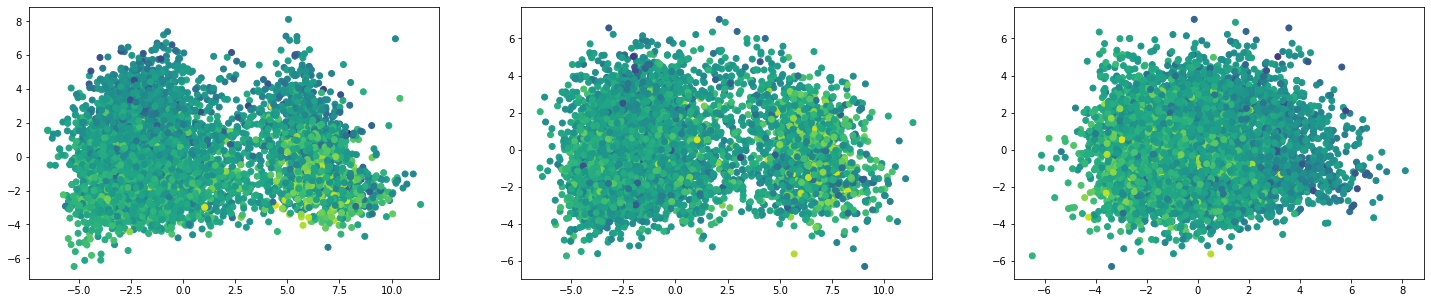

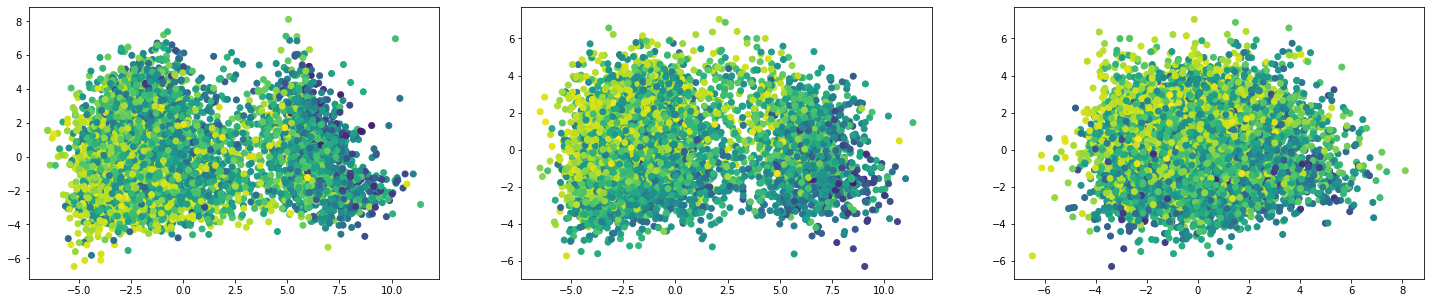

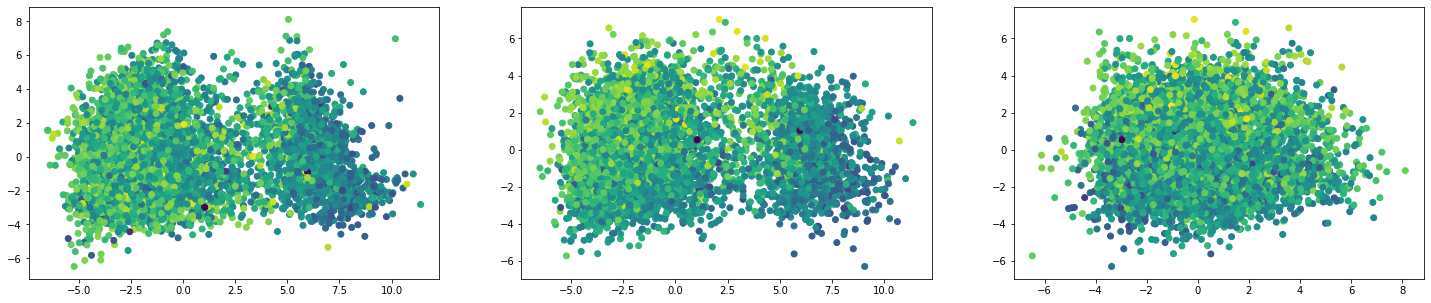

In [167]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train)

homo_lumo_gap_visualisation(X_pca, y_train, 20)

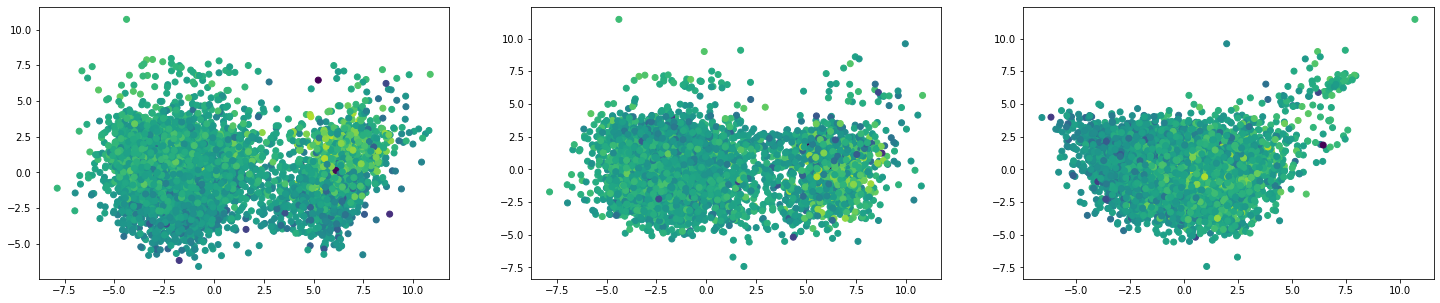

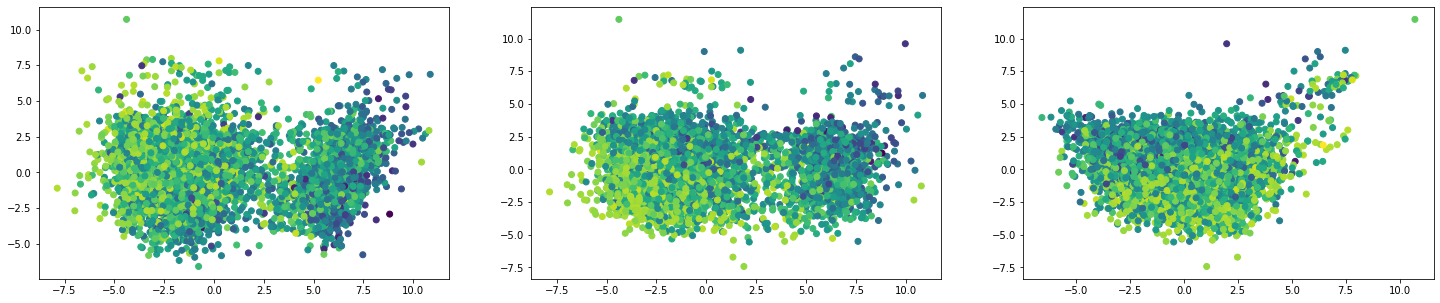

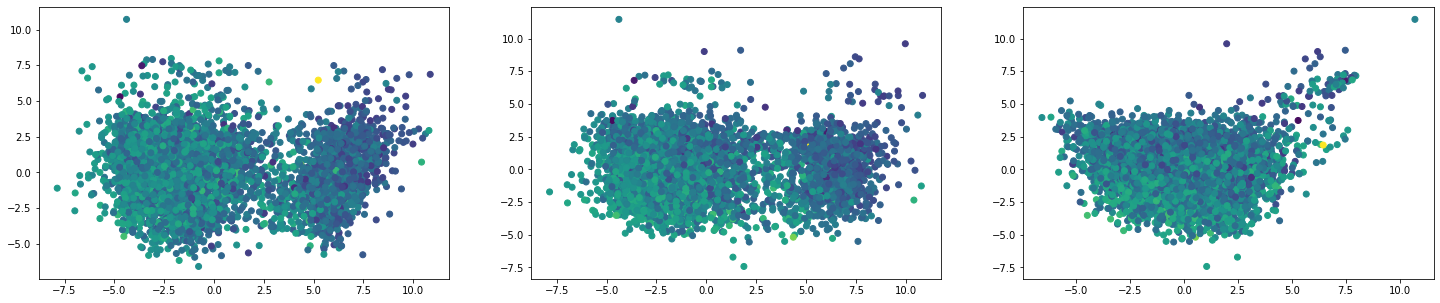

In [168]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_test)

homo_lumo_gap_visualisation(X_pca, y_test)

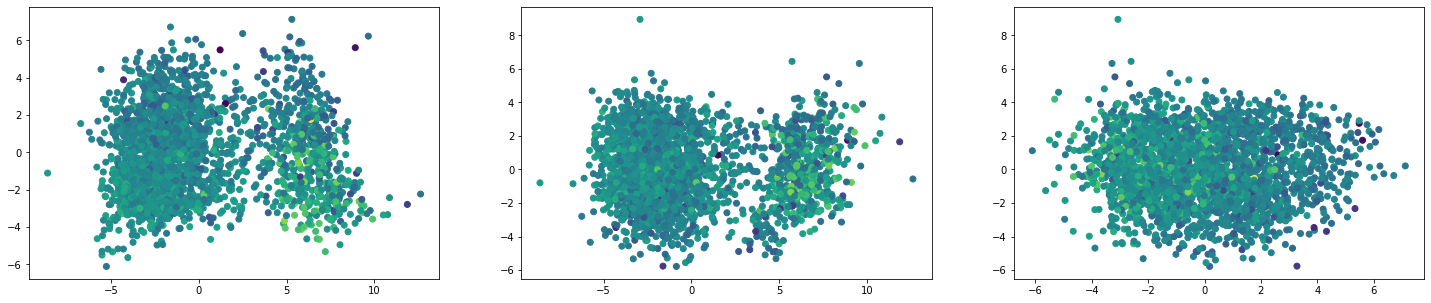

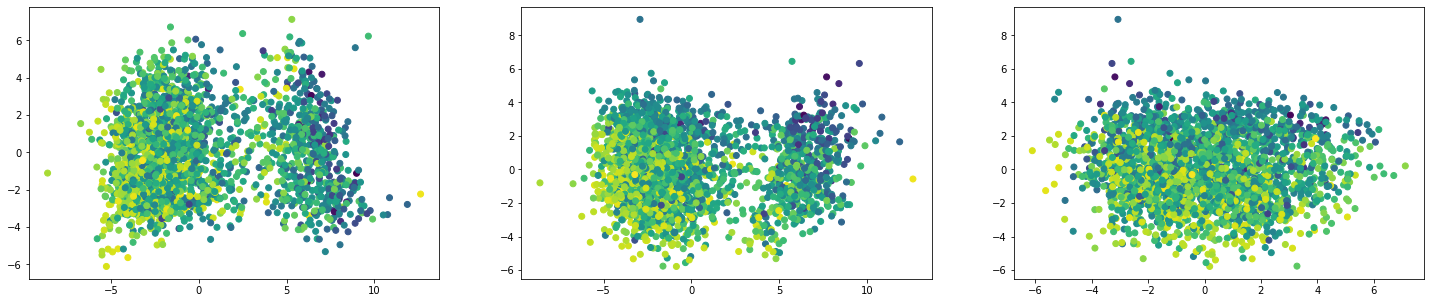

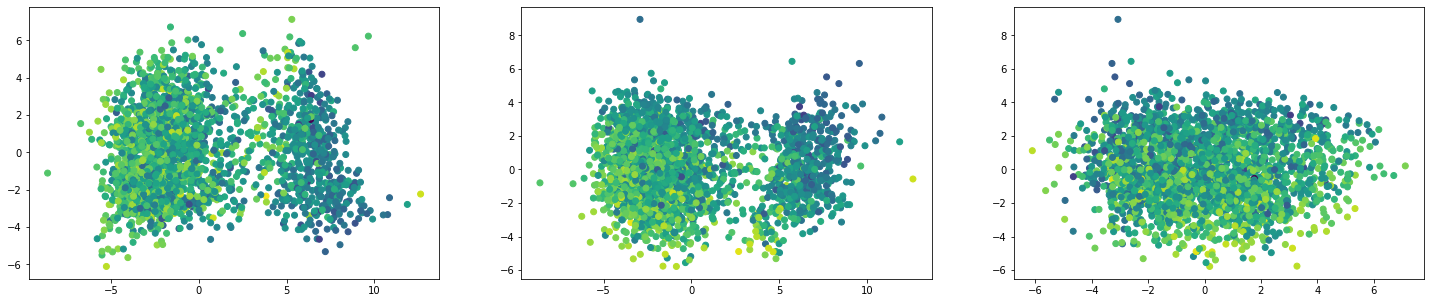

In [169]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_val)

homo_lumo_gap_visualisation(X_pca, y_val)

## Random Forest

In [ ]:
X = X_train
y = y_train.homo
val = y_test.homo

rf_regressor_homo = RandomForestRegressor(n_estimators=1000, n_jobs=20, criterion="mae")
rf_regressor_homo.fit(X, y)
y_prediction = rf_regressor_homo.predict(X_test)
get_mae_loss(y_prediction, val)

In [181]:
X = X_train
y = y_train.lumo
val = y_test.lumo

rf_regressor_lumo = RandomForestRegressor(n_jobs=20, criterion="mae")
rf_regressor_lumo.fit(X, y)
y_prediction = rf_regressor_lumo.predict(X_test)
get_mae_loss(y_prediction, val)

6.563977390331999

In [182]:
X = X_train
y = y_train.gap
val = y_test.gap

rf_regressor_gap = RandomForestRegressor(n_jobs=20, criterion="mae")
rf_regressor_gap.fit(X, y)
y_prediction = rf_regressor_gap.predict(X_test)
get_mae_loss(y_prediction, val)

0.546772632033

## Elastic net

In [183]:
X = X_train
y = y_train.homo
val = y_test.homo

rf_en_homo = ElasticNet()
rf_en_homo.fit(X, y)
y_prediction = rf_en_homo.predict(X_test)
get_mae_loss(y_prediction, val)

13.45063809801948

In [184]:
X = X_train
y = y_train.lumo
val = y_test.lumo

rf_en_lumo = ElasticNet()
rf_en_lumo.fit(X, y)
y_prediction = rf_en_lumo.predict(X_test)
get_mae_loss(y_prediction, val)

6.576299679726483

In [185]:
X = X_train
y = y_train.gap
val = y_test.gap

rf_en_gap = ElasticNet()
rf_en_gap.fit(X, y)
y_prediction = rf_en_gap.predict(X_test)
get_mae_loss(y_prediction, val)

0.9864817254884766

## Ridge regression

In [186]:
X = X_train
y = y_train.homo
val = y_test.homo

rf_ridge_homo = Ridge()
rf_ridge_homo.fit(X, y)
y_prediction = rf_ridge_homo.predict(X_test)
get_mae_loss(y_prediction, val)

13.447520164650799

In [187]:
X = X_train
y = y_train.lumo
val = y_test.lumo

rf_ridge_lumo = Ridge()
rf_ridge_lumo.fit(X, y)
y_prediction = rf_ridge_lumo.predict(X_test)
get_mae_loss(y_prediction, val)

6.553735918876277

In [188]:
X = X_train
y = y_train.gap
val = y_test.gap

rf_ridge_gap = Ridge()
rf_ridge_gap.fit(X, y)
y_prediction = rf_ridge_gap.predict(X_test)
get_mae_loss(y_prediction, val)

0.5562059047362976

# Additional information to run it in the console quickly
```
import torch;\
import torch.nn as nn;\
import torch.optim as optim;\
import torch.optim.lr_scheduler as lr_scheduler;\
from torch.utils.data import DataLoader;\
from torch.autograd import Variable;\
from tqdm import tqdm;\
import numpy as np;\
from CGRtools import smiles;\
from optparse import OptionParser;\
from collections import deque;\
from IPython.display import clear_output;\
from jtnn import *;\
import rdkit;\
lg = rdkit.RDLogger.logger();\
lg.setLevel(rdkit.RDLogger.CRITICAL);\
import math, random, sys;\
sys.path.insert(0, '/workspace/icml18-jtnn_original');\
from copy import copy;\
import pandas as pd;\
import matplotlib.pyplot as plt;\
from sklearn.decomposition import PCA;\
from sklearn.linear_model import ElasticNet, Ridge;\
from sklearn.ensemble import RandomForestRegressor;\
from sklearn.preprocessing import PolynomialFeatures;\
from sklearn.preprocessing import StandardScaler;\
vocab_path = "./data/qdb9/prunned/vocab.txt";\
vocab = [x.strip("\r\n ") for x in open(vocab_path)] ;\
vocab = Vocab(vocab);\
batch_size = 128;\
hidden_size = 450;\
latent_size = 256;\
depth = 3;\
stereo = True;\
modelvae_path = 'vae_model/qdb9_zinc_prunned_256/model';\
model = JTNNVAE(vocab, hidden_size, latent_size, depth, stereo=stereo);\
model.load_state_dict(torch.load(modelvae_path));model = model.cuda();\
model.eval();\
smile = model.sample_set();\
print(smile)
```